In [56]:
import torch
import pathlib
import cv2
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
%matplotlib inline

from passion.segmentation import prediction

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

# Load testing models

In [4]:
models_folder_path = pathlib.Path('../workflow/output/model')
rooftop_models_folder_path = models_folder_path / 'rooftop-segmentation'

# Sections models
model_mix_aug = torch.load(str(rooftop_models_folder_path / 'segments-mix-aug.pth'), map_location=torch.device(device))
model_mix_val19 = torch.load(str(rooftop_models_folder_path / 'segments-mix-val19.pth'), map_location=torch.device(device))
model_mix_val20 = torch.load(str(rooftop_models_folder_path / 'segments-mix-val20.pth'), map_location=torch.device(device))
model_z19 = torch.load(str(rooftop_models_folder_path / 'segments-z19.pth'), map_location=torch.device(device))
model_z19_aug = torch.load(str(rooftop_models_folder_path / 'segments-z19-aug.pth'), map_location=torch.device(device))
model_z20 = torch.load(str(rooftop_models_folder_path / 'segments-z20.pth'), map_location=torch.device(device))
model_z20_aug = torch.load(str(rooftop_models_folder_path / 'segments-z20-aug.pth'), map_location=torch.device(device))

# Rooftop models
model_inria_aug_10e = torch.load(str(rooftop_models_folder_path / 'inria-aug-10e.pth'), map_location=torch.device(device))
model_inria_aug_5e = torch.load(str(rooftop_models_folder_path / 'inria-aug-5e.pth'), map_location=torch.device(device))
model_inria_raw_10e = torch.load(str(rooftop_models_folder_path / 'inria-raw-10e.pth'), map_location=torch.device(device))
model_inria_raw_5e = torch.load(str(rooftop_models_folder_path / 'inria-raw-5e.pth'), map_location=torch.device(device))

# Testing folder paths

In [9]:
rid_test_folder = pathlib.Path('/storage/internal/home/r-pueblas/projects/rooftop-segmentation-datasets/data/RID/output/masks_segments_reviewed/test')
rid_test_folder_image = rid_test_folder / 'image'
rid_test_folder_label = rid_test_folder / 'label'

# Metrics

In [5]:
def intersect_and_union(pred_label, label, num_classes, ignore_index):
    mask = (label != ignore_index)
    pred_label = pred_label[mask]
    label = label[mask]

    intersect = pred_label[pred_label == label]
    area_intersect, _ = np.histogram(
        intersect, bins=np.arange(num_classes + 1))
    area_pred_label, _ = np.histogram(
        pred_label, bins=np.arange(num_classes + 1))
    area_label, _ = np.histogram(label, bins=np.arange(num_classes + 1))
    area_union = area_pred_label + area_label - area_intersect

    return area_intersect, area_union, area_pred_label, area_label

def angle_difference(angle_1, angle_2):
    a = angle_1 - angle_2
    a = (a + 180) % 360 - 180
    return a

def mean_angle_difference(pred_label, label, num_classes, angles, background_class, ignore_index):
    mask = (label != ignore_index)
    pred_label = pred_label[mask]
    label = label[mask]
    
    combined_pred_label = (pred_label != background_class).astype('uint8')
    combined_label = (label != background_class).astype('uint8')
    
    # Take those pixels where both images predict a class different than background
    pred_label_angles = pred_label[combined_pred_label == combined_label]
    pred_label_angles = pred_label_angles[pred_label_angles < len(angles)]
    label_angles = label[combined_pred_label == combined_label]
    label_angles = label_angles[label_angles < len(angles)]
    
    
    total_diff = 0
    for angle_1, angle_2 in zip(np.nditer(pred_label_angles, flags=['zerosize_ok']), np.nditer(label_angles, flags=['zerosize_ok'])):
        try:
            angle_1, angle_2 = angles[angle_1], angles[angle_2]
        except:
            print(angle_1, angle_2)
        diff = angle_difference(angle_1, angle_2)
        total_diff = total_diff + diff
    
    if pred_label_angles.size == 0:
        return None
    
    mean_diff = total_diff/pred_label_angles.size
    
    return mean_diff

# Helper functions

In [19]:
def test_model_sections(model, test_folder, num_classes, background_class, ignore_index, num_angles, output=True):
    start = time.time()
    
    test_folder_image = test_folder / 'image'
    test_folder_label = test_folder / 'label'

    angles = [i * (360/num_angles) for i in range(num_angles)]

    total_area_intersect = np.zeros((num_classes, ), dtype=float)
    total_area_union = np.zeros((num_classes, ), dtype=float)
    total_area_pred_label = np.zeros((num_classes, ), dtype=float)
    total_area_label = np.zeros((num_classes, ), dtype=float)
    total_angle_difference = 0

    for i, filename in enumerate(test_folder_image.glob('*.png')):
        image = cv2.imread(str(filename))
        label = cv2.imread(str(test_folder_label / filename.name))
        label = label[:,:,0]


        pred = prediction.segment_img(image, model, tile_size=512, stride=512, background_class=background_class)
        corrected_pred = pred.copy()
        corrected_pred[pred==0] = (background_class + 1)
        corrected_pred = (corrected_pred - 1)

        area_intersect, area_union, area_pred_label, area_label = \
                            intersect_and_union(corrected_pred, label, num_classes, ignore_index)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label

        mad = mean_angle_difference(corrected_pred, label, num_classes, angles, background_class, ignore_index)
        if mad: total_angle_difference += mad

        if i<5 and output:
            f, axarr = plt.subplots(1,3, figsize=(10, 10))
            axarr[0].imshow(image)
            axarr[1].imshow(label)
            axarr[2].imshow(corrected_pred)
            if i==0:
                axarr[0].title.set_text('Image')
                axarr[1].title.set_text('Ground truth')
                axarr[2].title.set_text('model_mix_aug')

            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            for ax in axarr:
                ax.axis('off')
            plt.show()

        iou = total_area_intersect / total_area_union

        if output: print(f'Processed image {filename.stem}, partial mean iou: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}, with background class: {np.mean(iou[~np.isnan(iou)])}, mean angle difference: {mad}')

    all_acc = total_area_intersect.sum() / total_area_label.sum()
    acc = total_area_intersect / total_area_label
    iou = total_area_intersect / total_area_union
    mad = total_angle_difference / (i+1)

    end = time.time()
    elapsed_time = (end - start)

    if output:
        print('\n')
        print(f'Elapsed time: {elapsed_time} seconds')
        print(f'Final IoU per class: {iou}')
        print(f'Final mean IoU with background class: {np.mean(iou[~np.isnan(iou)])}')
        print(f'Final mean IoU without background class: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}')
        print(f'Final mean angle difference: {mad}')

    return iou, np.mean(iou[~np.isnan(iou)]), mad, elapsed_time

def test_model_twolook(rooftop_model,
                       sections_model,
                       test_folder,
                       num_classes,
                       background_class_1,
                       background_class_2,
                       ignore_index,
                       num_angles,
                       output=True
                      ):
    start = time.time()
    
    test_folder_image = test_folder / 'image'
    test_folder_label = test_folder / 'label'

    angles = [i * (360/num_angles) for i in range(num_angles)]

    total_area_intersect = np.zeros((num_classes, ), dtype=float)
    total_area_union = np.zeros((num_classes, ), dtype=float)
    total_area_pred_label = np.zeros((num_classes, ), dtype=float)
    total_area_label = np.zeros((num_classes, ), dtype=float)
    total_angle_difference = 0

    for i, filename in enumerate(test_folder_image.glob('*.png')):
        image = cv2.imread(str(filename))
        label = cv2.imread(str(test_folder_label / filename.name))
        label = label[:,:,0]
    
        roofs = prediction.segment_img(image, rooftop_model, tile_size=512, stride=512, background_class=background_class_1)
        filtered = np.ones(image.shape).astype(np.uint8)
        idx=(roofs!=0)
        filtered[idx] = image[idx]

        pred = prediction.segment_img(filtered, sections_model, tile_size=512, stride=512, background_class=background_class_2)
        corrected_pred = pred.copy()
        corrected_pred[pred==0] = (background_class + 1)
        corrected_pred = (corrected_pred - 1)

        area_intersect, area_union, area_pred_label, area_label = \
                            intersect_and_union(corrected_pred, label, num_classes, ignore_index)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label

        mad = mean_angle_difference(corrected_pred, label, num_classes, angles, background_class, ignore_index)
        if mad: total_angle_difference += mad

        if i<5 and output:
            f, axarr = plt.subplots(1,3, figsize=(10, 10))
            axarr[0].imshow(image)
            axarr[1].imshow(label)
            axarr[2].imshow(corrected_pred)
            if i==0:
                axarr[0].title.set_text('Image')
                axarr[1].title.set_text('Ground truth')
                axarr[2].title.set_text('model_mix_aug')

            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            for ax in axarr:
                ax.axis('off')
            plt.show()

        iou = total_area_intersect / total_area_union

        if output: print(f'Processed image {filename.stem}, partial mean iou: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}, with background class: {np.mean(iou[~np.isnan(iou)])}, mean angle difference: {mad}')

    all_acc = total_area_intersect.sum() / total_area_label.sum()
    acc = total_area_intersect / total_area_label
    iou = total_area_intersect / total_area_union
    mad = total_angle_difference / (i+1)

    end = time.time()
    elapsed_time = (end - start)

    if output:
        print('\n')
        print(f'Elapsed time: {elapsed_time} seconds')
        print(f'Final IoU per class: {iou}')
        print(f'Final mean IoU with background class: {np.mean(iou[~np.isnan(iou)])}')
        print(f'Final mean IoU without background class: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}')
        print(f'Final mean angle difference: {mad}')

    return iou, np.mean(iou[~np.isnan(iou)]), mad, elapsed_time

# Results

In [11]:
num_classes = 18
background_class = 17
ignore_index = -1
num_angles = 16

/tmp/ipykernel_3938623/2237451141.py:51: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


In [14]:
print(f'Testing model <model_mix_aug>...')

iou, mean_iou, mad, elapsed_time = test_model_sections(model_mix_aug, rid_test_folder, num_classes, background_class, ignore_index, num_angles, output=False)

print(f'Mean IoU: {mean_iou}')
print(f'Mean angle difference: {mad} degrees')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model <model_mix_aug>...


/tmp/ipykernel_3938623/2237451141.py:51: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Mean IoU: 0.7059959351343941
Mean angle difference: -21.577800932676887 degrees
IoU per class: [0.67993732 0.75024663 0.71323271 0.74691143 0.67573962 0.50456439
 0.7314447  0.79515905 0.74074131 0.6999666  0.69286831 0.71339664
 0.58982006 0.49412315 0.73374546 0.81134676 0.67301386 0.96166884]
Elapsed time: 146.29339957237244 seconds.


In [15]:
print(f'Testing model <model_mix_val19>...')

iou, mean_iou, mad, elapsed_time = test_model_sections(model_mix_val19, rid_test_folder, num_classes, background_class, ignore_index, num_angles, output=False)

print(f'Mean IoU: {mean_iou}')
print(f'Mean angle difference: {mad} degrees')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model <model_mix_val19>...


/tmp/ipykernel_3938623/2237451141.py:51: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Mean IoU: 0.7531550469150653
Mean angle difference: -16.20632294923284 degrees
IoU per class: [0.78116735 0.76174636 0.79028055 0.80619657 0.72820372 0.52545848
 0.79072146 0.85061293 0.77119467 0.74014625 0.76397483 0.78482187
 0.68648253 0.40424874 0.78336129 0.84851556 0.77181501 0.96784266]
Elapsed time: 145.6363353729248 seconds.


In [16]:
print(f'Testing model <model_mix_val20>...')

iou, mean_iou, mad, elapsed_time = test_model_sections(model_mix_val20, rid_test_folder, num_classes, background_class, ignore_index, num_angles, output=False)

print(f'Mean IoU: {mean_iou}')
print(f'Mean angle difference: {mad} degrees')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model <model_mix_val20>...


/tmp/ipykernel_3938623/2237451141.py:51: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Mean IoU: 0.7370236573213111
Mean angle difference: -19.23266528621342 degrees
IoU per class: [0.75137555 0.70920686 0.75579015 0.79440881 0.69300843 0.53895328
 0.7634351  0.83479137 0.75448043 0.69859614 0.74017477 0.76892078
 0.64401693 0.53240474 0.76168433 0.84211886 0.72107065 0.96198864]
Elapsed time: 139.80415153503418 seconds.


In [26]:
print(f'Testing model <model_z19>...')

iou, mean_iou, mad, elapsed_time = test_model_sections(model_z19, rid_test_folder, num_classes, background_class, ignore_index, num_angles, output=False)

print(f'Mean IoU: {mean_iou}')
print(f'Mean angle difference: {mad} degrees')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model <model_z19>...


/tmp/ipykernel_3938623/1513032558.py:51: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Mean IoU: 0.29095039853222926
Mean angle difference: -34.80088528666459 degrees
IoU per class: [0.31972888 0.25757975 0.35950387 0.38204281 0.25422465 0.
 0.33697394 0.35677739 0.23408792 0.17436191 0.28232727 0.31734373
 0.15935428 0.         0.22382398 0.5144346  0.17393821 0.89060399]
Elapsed time: 144.11106276512146 seconds.


In [20]:
print(f'Testing model <model_z19_aug>...')

iou, mean_iou, mad, elapsed_time = test_model_sections(model_z19_aug, rid_test_folder, num_classes, background_class, ignore_index, num_angles, output=False)

print(f'Mean IoU: {mean_iou}')
print(f'Mean angle difference: {mad} degrees')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model <model_z19_aug>...


/tmp/ipykernel_3938623/1513032558.py:51: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Mean IoU: 0.2775709675686454
Mean angle difference: -33.49447935622619 degrees
IoU per class: [0.24660646 0.20049536 0.21967683 0.39833762 0.18164558 0.07646138
 0.28118077 0.30696202 0.26478893 0.09655301 0.23620125 0.37077178
 0.27741331 0.1091352  0.2653397  0.42057707 0.13376918 0.91036197]
Elapsed time: 131.2419855594635 seconds.


In [21]:
print(f'Testing model <model_z20>...')

iou, mean_iou, mad, elapsed_time = test_model_sections(model_z20, rid_test_folder, num_classes, background_class, ignore_index, num_angles, output=False)

print(f'Mean IoU: {mean_iou}')
print(f'Mean angle difference: {mad} degrees')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model <model_z20>...


/tmp/ipykernel_3938623/1513032558.py:51: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Mean IoU: 0.5991257021727997
Mean angle difference: -22.79417140563867 degrees
IoU per class: [6.70385108e-01 6.61281449e-01 6.76535406e-01 7.04346860e-01
 5.91729080e-01 5.04183359e-04 6.50657675e-01 7.84066825e-01
 7.10502856e-01 6.70045759e-01 5.48333005e-01 6.39731292e-01
 4.39837558e-01 1.55038760e-03 6.39690629e-01 8.00009124e-01
 6.39724742e-01 9.55330697e-01]
Elapsed time: 114.32256317138672 seconds.


In [22]:
print(f'Testing model <model_z20_aug>...')

iou, mean_iou, mad, elapsed_time = test_model_sections(model_z20_aug, rid_test_folder, num_classes, background_class, ignore_index, num_angles, output=False)

print(f'Mean IoU: {mean_iou}')
print(f'Mean angle difference: {mad} degrees')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model <model_z20_aug>...


/tmp/ipykernel_3938623/1513032558.py:51: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Mean IoU: 0.6648623734806555
Mean angle difference: -19.35116549581229 degrees
IoU per class: [0.62784522 0.62094736 0.72869829 0.74257018 0.64615709 0.44658038
 0.71264627 0.79118717 0.67881782 0.65064636 0.65273251 0.68185944
 0.59223605 0.31503747 0.6765217  0.78625277 0.6582319  0.95855475]
Elapsed time: 118.8921058177948 seconds.


# Two-look

In [23]:
num_classes = 18
background_class_1 = 0
background_class_2 = 17
ignore_index = -1
num_angles = 16

In [75]:
rooftop_models = [model_inria_raw_5e, model_inria_aug_5e, model_inria_raw_10e, model_inria_aug_10e]
sections_models = [model_z19, model_z19_aug, model_z20, model_z20_aug, model_mix_val19, model_mix_val20, model_mix_aug]

table_ious = np.zeros((len(rooftop_models), len(sections_models)))
table_mads = np.zeros((len(rooftop_models), len(sections_models)))

for i, rooftop_model in enumerate(rooftop_models):
    for j, section_model in enumerate(sections_models):
        print(f'Testing two look models {i} and {j}...')
        iou, mean_iou, mad, elapsed_time = test_model_twolook(rooftop_model,
                                                               section_model,
                                                               rid_test_folder,
                                                               num_classes,
                                                               background_class_1,
                                                               background_class_2,
                                                               ignore_index,
                                                               num_angles,
                                                               output=False)
        table_ious[i][j] = mean_iou
        table_mads[i][j] = mad
        print(f'Mean IoU: {mean_iou}')
        print(f'Mean angle difference: {mad} degrees')
        print(f'IoU per class: {iou}')
        print(f'Elapsed time: {elapsed_time} seconds.')

Testing two look models 0 and 0...


/tmp/ipykernel_3938623/1513032558.py:136: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Mean IoU: 0.1435689290348781
Mean angle difference: -39.33037754000422 degrees
IoU per class: [2.67971692e-01 2.25999161e-03 5.70448889e-02 6.86630746e-02
 1.19844487e-01 0.00000000e+00 5.84269019e-02 2.21448071e-01
 1.16838098e-01 1.13285273e-02 4.16554627e-02 1.06489174e-01
 1.10389771e-01 4.12677451e-05 5.12867029e-02 3.68943773e-01
 1.28736610e-01 8.52872228e-01]
Elapsed time: 288.67462134361267 seconds.
Testing two look models 0 and 1...
Mean IoU: 0.14368640158311172
Mean angle difference: -32.552575311284045 degrees
IoU per class: [1.71192719e-01 8.30242682e-04 3.61046131e-02 2.12691774e-01
 8.83666832e-02 1.34922184e-02 3.50129668e-02 1.50293107e-01
 1.79539852e-01 5.17367164e-03 5.41337255e-02 1.87400857e-01
 2.27961709e-01 2.37884015e-02 3.81672995e-02 2.28034781e-01
 7.02013593e-02 8.63969248e-01]
Elapsed time: 382.0678610801697 seconds.
Testing two look models 0 and 2...
Mean IoU: 0.24092008092225972
Mean angle difference: -41.65880388844078 degrees
IoU per class: [0.2731649

Mean IoU: 0.15748705949187058
Mean angle difference: -32.68443924064317 degrees
IoU per class: [0.19416608 0.00968494 0.06315735 0.25364391 0.10527548 0.01875938
 0.05397709 0.16516975 0.18545742 0.00731816 0.1003646  0.22508673
 0.21008243 0.03014473 0.04722367 0.23648963 0.06621306 0.86255263]
Elapsed time: 267.0939574241638 seconds.
Testing two look models 3 and 2...
Mean IoU: 0.26598172410848353
Mean angle difference: -42.38350395716616 degrees
IoU per class: [0.3137377  0.14736883 0.21232957 0.23725551 0.2235786  0.
 0.24042309 0.46803877 0.43349714 0.16165579 0.15591396 0.25447576
 0.19512469 0.         0.16585979 0.47905246 0.20932001 0.89003935]
Elapsed time: 239.67762804031372 seconds.
Testing two look models 3 and 3...
Mean IoU: 0.35622833800205705
Mean angle difference: -34.834340576574434 degrees
IoU per class: [0.44041543 0.21264897 0.2828633  0.42446144 0.3119025  0.08949698
 0.34481473 0.5236306  0.45368446 0.32435146 0.38673982 0.43296963
 0.31983773 0.05468917 0.242121

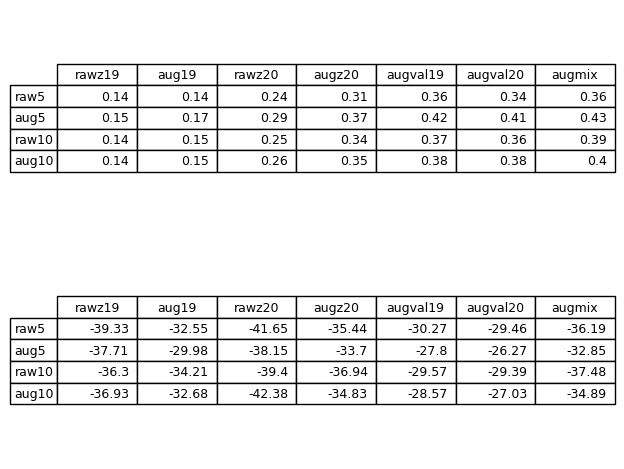

In [77]:
table_ious_rounded = (table_ious * 100).astype('int') / 100
table_mads_rounded = (table_mads * 100).astype('int') / 100
ious_df = pd.DataFrame(data=table_ious_rounded,
             index=['raw5','aug5','raw10','aug10'],
             columns=['rawz19','aug19','rawz20','augz20','augval19','augval20','augmix'])
mads_df = pd.DataFrame(data=table_mads_rounded,
             index=['raw5','aug5','raw10','aug10'],
             columns=['rawz19','aug19','rawz20','augz20','augval19','augval20','augmix'])

fig, ax = plt.subplots(2,1)

# hide axes
fig.patch.set_visible(False)
ax[0].axis('off'), ax[1].axis('off')
ax[0].axis('tight'), ax[1].axis('tight')

ax[0].table(cellText=ious_df.values, rowLabels=ious_df.index, colLabels=ious_df.columns, loc='center')
ax[1].table(cellText=mads_df.values, rowLabels=mads_df.index, colLabels=mads_df.columns, loc='center')

fig.tight_layout()

plt.show()